In [1]:
import numpy as np     # import numpy
import landlab         # import landlab

from landlab import RasterModelGrid   # rastermodel sub classes
from landlab.io import read_esri_ascii  # reading an esri ascii file
from landlab.plot import imshow_grid   # for plotting
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

from landlab.components import FlowAccumulator,KinwaveImplicitOverlandFlow # import our flow accumulator 
# from generate_overland_flow_implicit_kinwave import KinwaveImplicitOverlandFlow # import our kinematic wave component
from landlab.components.flow_accum import find_drainage_area_and_discharge  # reports drainage area or flow volume of a grid
import rioxarray as rix
import geopandas as gpd
import xarray as xr
import glob
import pandas as pd

# Prepare my inputs for landlab

## DEM

Open up the DEM that openAMUNDSEN uses and replace NaNS with -9999, the no data value that landlab expects, and save that to a new file

In [2]:
east_dem = rix.open_rasterio('/Users/elischwat/Development/snow-hydrology/modules/data/openamundsen/dem_uppereastriver_50.asc')

In [3]:
east_dem_filled_with_nodata = east_dem.fillna(-9999).rio.set_nodata(-9999)

Crop using the east river polygon

In [4]:
watershed_boundary_gdf = gpd.read_file("../data/east_polygon.json")

In [5]:
east_dem_filled_with_nodata = east_dem_filled_with_nodata.rio.clip(watershed_boundary_gdf.geometry, drop=True)

Save to asc

In [6]:
east_dem_filled_with_nodata.rio.to_raster(
    '/Users/elischwat/Development/snow-hydrology/modules/data/openamundsen/dem_uppereastriver_50_with_nodatas.asc',
    driver='AAIGrid'
)

## Runoff

Open the outputs file 

In [7]:
runoff_model_output_raw = xr.open_dataset('/Users/elischwat/Development/snow-hydrology/modules/lab8/openamundsen_results/output_grids.nc')
runoff_model_output_raw

<xarray.Dataset> Size: 640MB
Dimensions:  (time: 1696, y: 337, x: 280)
Coordinates:
  * time     (time) datetime64[ns] 14kB 2022-11-16 ... 2023-06-15T21:00:00
  * x        (x) float64 2kB 3.226e+05 3.226e+05 ... 3.365e+05 3.365e+05
  * y        (y) float64 3kB 4.322e+06 4.322e+06 ... 4.306e+06 4.306e+06
    crs      int64 8B ...
Data variables:
    melt     (time, y, x) float32 640MB ...
Attributes:
    Conventions:  CF-1.7

(19454.0, 19568.0)

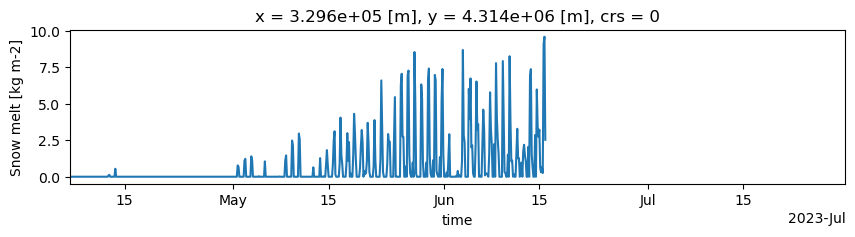

In [8]:
runoff_model_output_raw.sel(
    x = 329575.0,
    y = 4314025.0
)['melt'].plot(figsize=(10,2))
plt.xlim(pd.to_datetime('2023-04-07'), pd.to_datetime('2023-07-30'))

Limit runoff dataset to beginning of May

In [9]:
runoff_model_output_raw = runoff_model_output_raw.sel(
    time = slice('2023-04-07', runoff_model_output_raw.time.max())
)

Save each timesteps runoff grid to an ascii file

In [10]:
rm -rf /Users/elischwat/Development/snow-hydrology/modules/data/openamundsen/timestepped_runoff/

In [11]:
mkdir /Users/elischwat/Development/snow-hydrology/modules/data/openamundsen/timestepped_runoff/

In [12]:
for t in runoff_model_output_raw.time:
    opened_raster = runoff_model_output_raw.sel(time = t)
    opened_runoff_grid = opened_raster['melt'].fillna(-9999).rio.set_nodata(-9999)
    opened_runoff_grid.rio.to_raster(
        f"/Users/elischwat/Development/snow-hydrology/modules/data/openamundsen/timestepped_runoff/{int(t.values)}.asc",
        driver='AAIGrid'
    )
    

# Run the landlab routing model

## Open the DEM and look at it 

In [13]:
(rmg,Z)=read_esri_ascii(
    '/Users/elischwat/Development/snow-hydrology/modules/data/openamundsen/dem_uppereastriver_50_with_nodatas.asc', 
    name='topographic__elevation'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_49598/1560358502.py:1: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  (rmg,Z)=read_esri_ascii(


Min elevation (m)= 2720.8
Max elevation (m)= 4102.7
Outlet ID = [518]


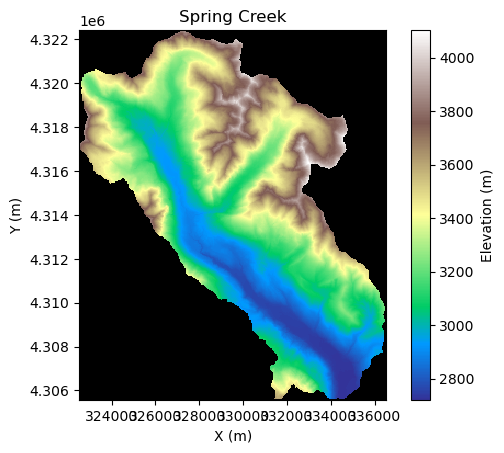

In [14]:
oid = rmg.set_watershed_boundary_condition('topographic__elevation', return_outlet_id=True) # finds the outlet and closes the watershed boundaries

#map your watershed
imshow_grid(rmg,'topographic__elevation', plot_name = 'Spring Creek', 
            var_name = 'Elevation', var_units = 'm', grid_units = ('m','m'), cmap = 'terrain')

Zmin=np.min(rmg.at_node['topographic__elevation'][rmg.core_nodes])  #let's find the lowest point to scale our lapse rate
Zmax=np.max(rmg.at_node['topographic__elevation'][rmg.core_nodes])  # maximum elevation 

print('Min elevation (m)=', np.round(Zmin,1))
print('Max elevation (m)=', np.round(Zmax,1))
print('Outlet ID =', oid)

## Gather runoff files and open one

In [15]:
runoff_files = sorted(
    glob.glob("/Users/elischwat/Development/snow-hydrology/modules/data/openamundsen/timestepped_runoff/**.asc")
)
len(runoff_files)

560

In [16]:
# Read in spatially distributed runoff as a separate grid called runopff_grid
# with a field called runoff. These data are in m, so we have to do some conversions.
(runoff_grid, rl) = read_esri_ascii(runoff_files[300], name='runoff')

# The runoff rate comes in mm per the whole timestep, which is 3 hours
# convert to mm/hr, the correct units for landlab inputs
rr_mmhr = rl/3 #runoff rate in mm/hr

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_49598/537465389.py:3: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  (runoff_grid, rl) = read_esri_ascii(runoff_files[300], name='runoff')


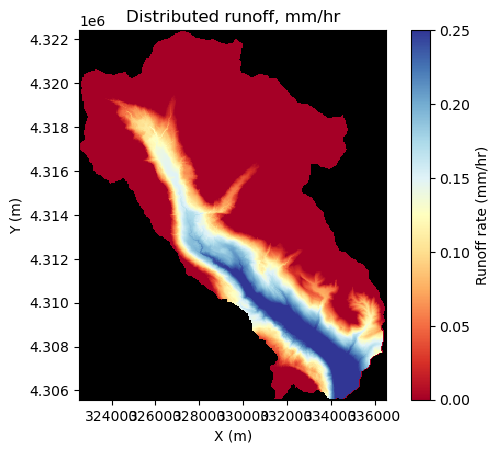

In [17]:
_=rmg.add_field('runoff_mmhr', rr_mmhr, at='node', clobber=True)

imshow_grid(rmg,'runoff_mmhr', plot_name='Distributed runoff, mm/hr', var_name='Runoff rate', 
            var_units='mm/hr', grid_units=('m','m'), cmap='RdYlBu', vmin=0, vmax=0.25)
plt.show()

### Determine maximum discharge at the watershed outlet (+ other locations!) using only FlowAccumulator

In [18]:
# Instantiate Landlab FlowAccumulator using 'MFD' as the flow director, spatially distributed runoff field in m/s, and
# use the partition method 'square_root_of_slope' to match instantiation of FlowAccumulator in Kinwave component
fa = FlowAccumulator(rmg,
                     surface='topographic__elevation',
                     flow_director='MFD', #multiple flow directions
                     runoff_rate='runoff_mmhr', 
                     partition_method='square_root_of_slope')

In [19]:
# Run method to get drainage area and discharge at each node
(drainage_area, discharge) = fa.accumulate_flow()

# Check to see how many of the core nodes are sinks
sinks = rmg.at_node['flow__sink_flag'][rmg.core_nodes].sum()

if sinks < 0.01*rmg.core_nodes.sum():
    print(sinks, r'of the core nodes are sinks. This is less than 1% of the core nodes. Code can continue.')
else:
    print(sinks, r'of the core nodes are sinks. This is more than 1% of the core nodes. \
        Consider using a DEM that has been pre-processed for sinks.')

643 of the core nodes are sinks. This is less than 1% of the core nodes. Code can continue.


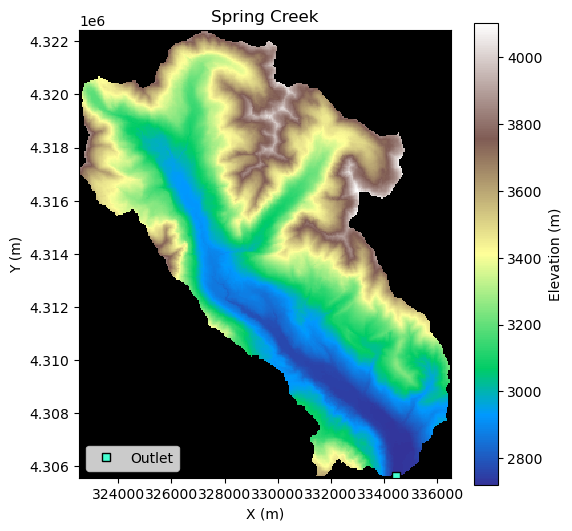

In [20]:
# Set up the figure.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

imshow_grid(rmg, Z, plot_name='Spring Creek', var_name='Elevation', var_units='m', grid_units=('m', 'm'), 
          cmap='terrain', color_for_closed='black')

# Plot the sample nodes.
plt.plot(rmg.node_x[oid], rmg.node_y[oid], 's', color='#44FFD1', markeredgecolor='k', label='Outlet')
# plt.plot(rmg.node_x[mid], rmg.node_y[mid], '^', color='#6153CC', markeredgecolor='k', label='Midstream')
# plt.plot(rmg.node_x[uid], rmg.node_y[uid], 'o', color='#A60067', markeredgecolor='k',label='Upstream')

_ = ax.legend(loc='lower left')

Outlet discharge (m^3/s) = [31463.3]
Outlet runoff (mm) = [19192843.29]


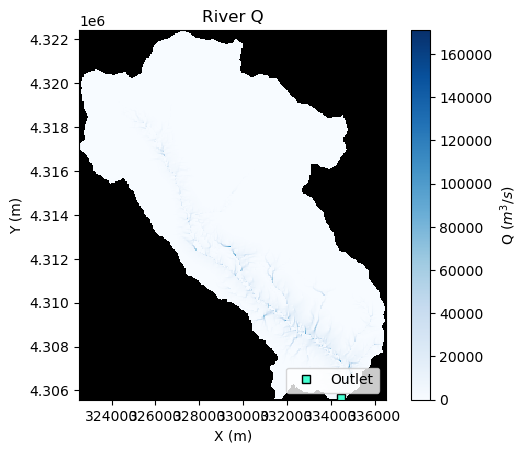

In [21]:
# Obtain discharge at the outlet, midstream, and upstream nodes in mm
discharge_oid = rmg.at_node['surface_water__discharge'][oid]
# discharge_mid = rmg.at_node['surface_water__discharge'][mid]
# discharge_uid = rmg.at_node['surface_water__discharge'][uid]

# Calculate runoff at the outlet, midstream, and upstream nodes in mm
runoff_oid=1000.*86400.*((rmg.at_node['surface_water__discharge'][oid]))/(drainage_area[oid])
# runoff_mid=1000.*86400.*((rmg.at_node['surface_water__discharge'][mid]))/(drainage_area[mid])
# runoff_uid=1000.*86400.*((rmg.at_node['surface_water__discharge'][uid]))/(drainage_area[uid])

print('Outlet discharge (m^3/s) =', np.round(discharge_oid,2))
print('Outlet runoff (mm) =', np.round(runoff_oid,2))
# print('Midstrean discharge (m^3/s) =', np.round(discharge_mid,2))
# print('Midstream runoff (mm) =', np.round(runoff_mid,2))
# print('Upstream discharge (m^3/s) =', np.round(discharge_uid,2))
# print('Upstream runoff (mm) =', np.round(runoff_uid,2))

# Map surface water discharge when outlet is at its maximum
imshow_grid(rmg,'surface_water__discharge', plot_name='River Q', 
            var_name='Q', var_units='$m^3/s$', grid_units=('m','m'), 
            cmap='Blues')

# Plot the sample nodes.
plt.plot(rmg.node_x[oid], rmg.node_y[oid], 's', color='#44FFD1', markeredgecolor='k', label='Outlet')
# plt.plot(rmg.node_x[mid], rmg.node_y[mid], '^', color='#6153CC', markeredgecolor='k', label='Midstream')
# plt.plot(rmg.node_x[uid], rmg.node_y[uid], 'o', color='#A60067', markeredgecolor='k',label='Upstream')

_ = plt.legend(loc='lower right')

In [22]:
# Instantiate kinwave component
knwv = KinwaveImplicitOverlandFlow(rmg, runoff_rate=rr_mmhr, roughness=0.03, depth_exp=5/3) #Feed initial component a distributed runoff rate

In [23]:
rr_mmhr > 0

array([False, False, False, ..., False, False, False])

In [24]:
knwv.runoff_rate = rr_mmhr

In [25]:
# each runoff file is named by integer time, so parse the first and last runoff 
# grid files to get the simulation start and end times
simulation_start_time = pd.to_datetime(int(runoff_files[0].split('/')[-1].replace('.asc', '')))
simulation_end_time = pd.to_datetime(int(runoff_files[-1].split('/')[-1].replace('.asc', '')))
dt = 60*60*3 # seconds in three hours

In [26]:
# Initialize model run information
hydrograph_time = [0]
discharge_outlet = [0]
discharge_midstream = [0]
discharge_upstream = [0]

elapsed_time = 0
model_run_time= 30*24*60*60 #total model run time, in seconds; 30 days

In [27]:
from tqdm import tqdm

In [28]:
# Run the model; note that this will take a bit of time!
for runoff_file in tqdm(runoff_files):
    # Read in spatially distributed runoff as a separate grid called runopff_grid
    # with a field called runoff. These data are in m, so we have to do some conversions.
    (runoff_grid, rl) = read_esri_ascii(runoff_file, name='runoff')

    # The runoff rate comes in mm per the whole timestep, which is 3 hours
    # convert to mm/hr, the correct units for landlab inputs
    rr_mmhr = rl/3 #runoff rate in mm/hr

    _=rmg.add_field('runoff_mmhr', rr_mmhr, at='node', clobber=True)
    
    knwv.runoff_rate = rr_mmhr

    knwv.run_one_step(dt)

    q_outlet = rmg.at_node['surface_water_inflow__discharge'][oid].item()
    discharge_outlet.append(q_outlet)

  0%|          | 0/560 [00:00<?, ?it/s]/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_49598/1283616497.py:5: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  (runoff_grid, rl) = read_esri_ascii(runoff_file, name='runoff')
100%|██████████| 560/560 [1:44:48<00:00, 11.23s/it]   


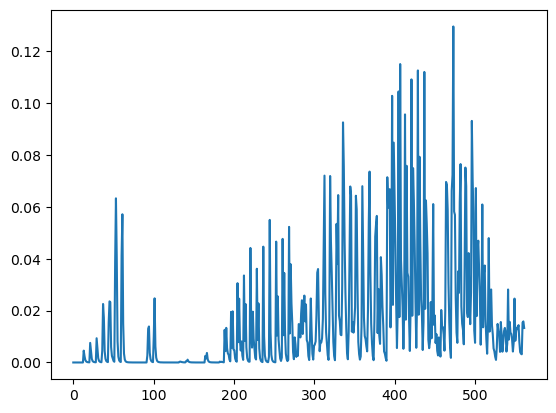

In [30]:
plt.plot(np.linspace(0,len(discharge_outlet),len(discharge_outlet)), discharge_outlet)